# Logistic and linear regression with first order methods

Notebook to play with a few first order optimization methods. Currently covers proximal algorithms for l1 and l2 regularization as well as more recent stochastic methods like SAG and MISO. Optimization is done either on the least squares or logistic loss.

### Table of content

[1. Loss function and gradients](#loss)<br>
[2. Proximal gradient derived from a majorization-minimization method](#mm_method)<br>
[3. Proximal operators](#prox)<br>
[4. Full gradient methods (GD, ISTA, FISTA)](#full)<br>
[5. Stochastic methods (SGD, SAG, MISO, SDCA, SVRG)](#stoc)<br>
[6. Generate  dataset](#data)<br>
[7. Optimize (full gradient)](#optf)<br>
[8. Optimize (stochastic)](#opts)<br>
[Appendix](#appendix)

In [81]:
import numpy as np
from numpy.linalg import norm

%matplotlib inline
import matplotlib.pylab as plt

<a id='loss'></a> 
## Loss functions and gradients

Least squares:

$$
\begin{align*}
\ell(\theta; \mathbf{x}, \mathbf{y}) = \frac{1}{2n}\sum_{i=1}^n(\theta^Tx_i - y_i)^2 \\
\frac{\partial \ell(\theta; \mathbf{x}, \mathbf{y})}{\partial\theta} = \frac{1}{n}\sum_{i=1}^n(\theta^Tx_i - y_i)x_i \\ 
\end{align*}
$$

We use 2D numpy array for `features` and `labels` to take advantage of array magic.

In [141]:
def least_squares(x, features, labels):
    """Evaluates the least square function."""
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)
    loss_array = 1/2*(features.dot(x.T) - labels) ** 2
    return np.sum(loss_array, axis=0)

In [142]:
def least_squares_grad(x, features, labels):
    """Evaluates the gradient of the least square function."""
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
    grad_array = (features.dot(x.T) - labels) * features
    return np.sum(grad_array, axis=0) / n_samples

Logistic and loss:
$$
\begin{align*}
s(x) & = \frac{1}{1+e^{-x}} \\
\ell(\theta; \mathbf{x}, \mathbf{y}) & = \frac{1}{n}\sum_{i=1}^n\log(1 + e^{(-y_i\theta^Tx_i)}) \\
\frac{\partial \ell(\theta; \mathbf{x}, \mathbf{y})}{\partial\theta} & = \frac{1}{n}\sum_{i=1}^n\frac{-y_i x_i}{1+\exp(y_i\theta^T x_i)}
\end{align*}
$$

In [143]:
logistic = lambda x: 1. / (1. + np.exp(-x))

In [123]:
def logistic_loss(x, features, labels):
    """Evaluates the logistic loss function."""
    n_samples, n_features = features.shape
    x = x.reshape(1, n_features)
    loss_array = np.log(1 + np.exp(-labels * features.dot(x.T)))
    return np.sum(loss_array, axis=0) / n_samples

In [124]:
def logistic_loss_grad(x, features, labels):
    """Evaluates the gradient of the logistic loss."""
    n_samples = features.shape[0]
    x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
    grad_array = -labels / (1 + np.exp(labels * features.dot(x.T))) * features
    return np.sum(grad_array, axis=0) / n_samples

<a id='mm_method'></a> 
## Proximal gradient derived from a majorization-minimization method

Let's say we would like to minimize $f + g$, with $f: \mathbb{R}^n \rightarrow \mathbb{R}$ a convex, $\beta$-smooth function and $g$ a convex function with a simple proximal operator.

A simple upper bound on $f+g$ is:

$$
\begin{align*} 
f(y) + g(y) & \leq \{f(x) + \nabla{f(x)^T}(y - x) + \frac{1}{2\lambda}\|x-y\|_{2}^2 + g(y)\\
& = q_\lambda(x, y),
\end{align*}
$$
where $\lambda \in (0, 1/\beta]$.

Iteratively minimizing $q_\lambda(x^t, \cdot)$ will converge the minimum of $f+g$ 
$$
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\prox}{prox}
$$
$$
\begin{align*} 
\argmin_x q_\lambda(x^t, x) & = \argmin_x \{f(x^t) + \nabla{f(x^t)^T}(x - x^t) + \frac{1}{2\lambda}\|x-x^t\|_{2}^2 + g(x)\} \\ 
& = \argmin_x \{\frac{1}{2}\|x - (x^t - \lambda\nabla f(x^t))\|_2^2 + \lambda g(x)\} \\
& = \text{prox}_{\lambda g}\left(x^t - \lambda\nabla f(x^t)\right) \\
\end{align*}
$$

<a id='prox'></a> 
## Proximal operators

The derivation of the proximal operators leads to:

$$
\begin{align*}
\text{prox}_{\lambda\|\cdot\|_1}(v) & = \text{sign}(v) \odot (|v| − \lambda)_+ \\
\text{prox}_{\lambda\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda} v \\
\text{prox}_{\lambda_1\|\cdot\|_1 + \lambda_2 / 2\|\cdot\|_2^2}(v) & = \frac{1}{1 + \lambda_2} \text{sign}(v) \odot (|v| - \lambda_1)_+
\end{align*}
$$

In [144]:
# input: xk
# alpha_k * grad
def prox_l1(x, l=1.):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x)
    return np.sign(x) * (x_abs - l) * (x_abs > l)

def prox_l2(x, l=1.):
    """ Proximal operator of the l2 norm."""
    return 1. / (1 + l) * x

def prox_enet(x, l_l1, l_l2, t=1.):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    prox_l1 = np.sign(x) * (x_abs - t * l_l1) * (x_abs > t * l_l1)
    return prox_l1 / (1. + t * l_l2)

<a id='full'></a> 
## Full gradient methods (GD, ISTA, FISTA)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [145]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk)
        err = norm(xk - x_real) / norm(x_real)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
            if it[0] % (n_iter / 5) == 0:
                print ' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

And now we can implement the algorithms.

In [146]:
def gd(x_init, grad, n_iter=100, step=1., callback=None):
    """Basic gradient descent algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x -= step * grad(x)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [147]:
def ista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x), step)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [148]:
def fista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    
    for _ in range(n_iter):
        x_new = prox(y - step * grad(y), step)
        t_new = (1. + (1. + 4. * t**2)**.5) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x = x_new

        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

<a id='stoc'></a> 
## Stochastic methods (SGD, SAG, MISO, SVRG)

Same but for (more recent) stochastic algorithms.

In [149]:
def sgd(x_init, features, labels, grad, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    n_samples, n_features = features.shape
    
    for i in range(n_iter):
        idx = np.random.randint(n_samples)
        feature = features[idx].reshape(1, n_features)
        label = labels[idx]
        x -= step * grad(x, feature, label) / (n_samples * np.sqrt(i + 1))
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [150]:
def sag(x_init, features, labels, grad, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    
    n_samples, n_features = features.shape
    y_old = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    
    for _ in range(n_iter):
        idx = np.random.randint(n_samples)
        feature = features[idx].reshape(1, n_features)
        label = labels[idx]
        y_new = grad(x, feature, label)
        y += (y_new - y_old[idx]) / n_samples
        y_old[idx] = y_new
        x -= step * y / n_samples
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x
    

In [151]:
def miso(x_init, features, labels, grad, prox, n_iter=100, step=1., callback=None):
    """MISO algorithm."""
    x = x_init.copy()
    
    n_samples, n_features = features.shape
    z_old = np.zeros((n_samples, n_features))
    z = np.zeros(n_features)
    
    for _ in range(n_iter):
        idx = np.random.randint(n_samples)
        feature = features[idx].reshape(1, n_features)
        label = labels[idx]
        z_new = grad(x, feature, label) 
        z += (z_new - z_old[idx]) / n_samples
        z_old[idx] = z_new
        x = prox(x - step * z, step)
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

In [152]:
def svrg(x_init, features, labels, grad, n_iter=100, batch_size=10, step=1., callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    
    n_samples, n_features = features.shape
    x_old = sgd(x_init, features, labels, grad, n_iter=batch_size, step=step, callback=None)
    mu = grad(x_old, features, labels)
    
    x = x_old
    for i in range(n_iter):
        if i % batch_size == 0:
            x_old = x
            mu = grad(x, features, labels)
        idx = np.random.randint(n_samples)
        feature = features[idx].reshape(1, n_features)
        label = labels[idx]
        z_new = grad(x, feature, label)
        z_old = grad(x_old, feature, label)
        x -= step * (z_new - z_old + mu) / n_samples
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

<a id='data'></a> 
## Generate  dataset

We test the above algorithms on a generated dataset. 

In [153]:
# Generate a fake dataset

n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
diag = np.random.rand(n_features)
features = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())

cond = 109.56


In [154]:
# Change this to 'False' to estimate the logitic regression model.
linear = True
if linear == True:
    residuals = np.random.randn(n_samples, 1)
    labels = features.dot(params.T) + residuals
else:
    labels = np.array([[float(np.random.rand() < p)] for p in logistic(features.dot(params.T))])

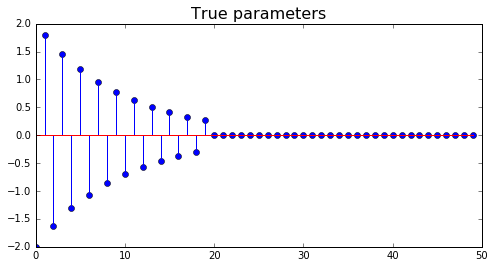

In [155]:
plt.figure(figsize=(8, 4))
plt.stem(params[0])
plt.title("True parameters", fontsize=16)
plt.show()

<a id='optf'></a> 
## Optimize (full gradient)

### Choosing the step size

All algorithms use a constant step size set to $1/L$, where $L$ is a Lipschitz constant for the gradient of the loss.

1.Least squares

$$L = \frac{ \|\mathbf{x}^T \mathbf{x}\|_{op}}{n}$$

2.Logistic loss
$$L = \frac{\underset{i}{\max}(\|x_i\|_2^2)}{4n} $$

In [156]:
# Initialize stuff
x_init = 1 - 2 * np.random.rand(1, n_features)
n_iter = 30
l_l1 = 0.0
l_l2 = 0.1

print x_init.shape
print features.shape
print labels.shape
print params.shape

# f and gradient
if linear == True:
    f = lambda x: least_squares(x, features, labels)
    grad_f = lambda x: least_squares_grad(x, features, labels)
    step = norm(features.T.dot(features) / n_samples, 2)
else:
    f = lambda x: logistic_loss(x, features, labels)[0]
    grad_f = lambda x: logistic_loss_grad(x, features, labels)
    step = 1. # np.sum(features**2, axis=1).max() / (4 * n_samples)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x: prox_l1(x, l_l1)

print "Type: %s" % ('linear' if linear else 'logistic')
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

(1, 50)
(2000, 50)
(2000, 1)
(1, 50)
Type: linear
n_iter: 30
step size: 1.07


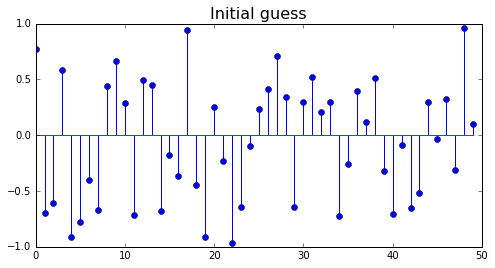

In [157]:
plt.figure(figsize=(8, 4))
plt.stem(x_init[0])
plt.title("Initial guess", fontsize=16)
plt.show()

In [158]:
# ISTA
ista_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_ista = ista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=ista_inspector)

TypeError: <lambda>() takes exactly 1 argument (2 given)

In [159]:
# FISTA
fista_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_fista = fista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=fista_inspector)

TypeError: <lambda>() takes exactly 1 argument (2 given)

In [160]:
# Gradient descent
grad_gd = lambda x: grad_f(x) + l_l1 * np.abs(x)
gd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_gd = gd(x_init, grad=grad_gd, n_iter=n_iter, step=step, callback=gd_inspector)

   it    |   obj    |   err   
       0 | 0.00e+00 | 8.65e-01
       6 | 0.00e+00 | 5.95e-01
      12 | 0.00e+00 | 4.88e-01
      18 | 0.00e+00 | 4.14e-01
      24 | 0.00e+00 | 3.57e-01


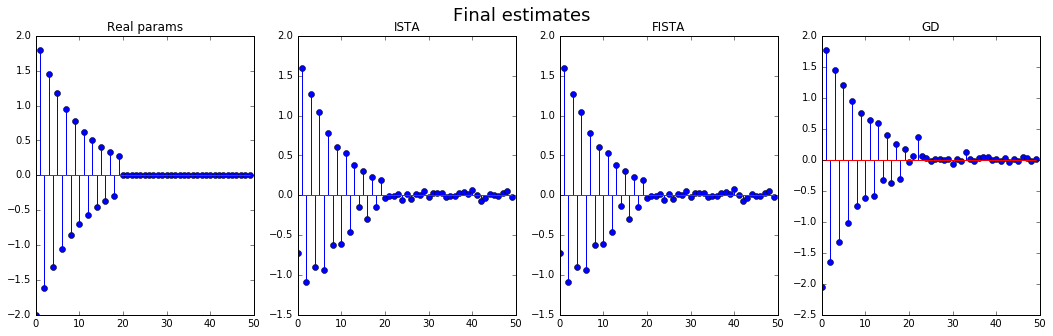

In [139]:
plt.figure(figsize=(18, 5))
plt.suptitle("Final estimates", fontsize=18)
plt.subplot(1, 4, 1)
plt.title("Real params")
plt.stem(params[0])
plt.subplot(1, 4, 2)
plt.title("ISTA")
plt.stem(x_ista[0], color='red')
plt.subplot(1, 4, 3)
plt.title("FISTA")
plt.stem(x_fista[0])
plt.subplot(1, 4, 4)
plt.title("GD")
plt.stem(x_gd[0])
plt.show()

In [ ]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(gd_inspector.obj, 'b')
plt.plot(ista_inspector.obj, 'r')
plt.plot(fista_inspector.obj, 'g')
plt.title("Loss", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.legend(["gd", "ista", "fista"])
plt.subplot(1, 2, 2)
plt.plot(gd_inspector.err, 'b')
plt.plot(ista_inspector.err, 'r')
plt.plot(fista_inspector.err, 'g')
plt.title("Distance to x_real", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("distance", fontsize=14)
plt.legend(["gd", "ista", "fista"])
plt.show()

<a id='opts'></a> 
## Optimize (stochastic)

In [ ]:
n_iter = 10 * n_samples

# Initialize stuff
if linear == True:
    f = lambda x: least_squares(x, features, labels)[0]
    grad_stoc = least_squares_grad
    L = norm(features.T.dot(features), 2)  / n_samples
else:
    f = lambda x: logistic_loss(x, features, labels)[0]
    grad_stoc = logistic_loss_grad
    L = 1. #4. * n_samples / np.sum(features**2, axis=1).max()

print "Type: %s" % ('linear' if linear else 'logistic')
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

In [ ]:
plt.figure(figsize=(8, 4))
plt.stem(x_init[0])
plt.title("Initial guess", fontsize=16)
plt.show()

In [ ]:
grad_step = 10. / L
grad_sgd = lambda x, feat, lab: grad_stoc(x, feat, lab) + l_l2 * x[0]
sgd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_sgd = sgd(x_init, features=features, labels=labels, grad=grad_sgd, n_iter=n_iter, step=step, callback=sgd_inspector)

In [ ]:
sag_step = 1. / L
grad_sag = lambda x, feat, lab: grad_stoc(x, feat, lab) + l_l2 * x[0]
sag_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_sag = sag(x_init, features=features, labels=labels, grad=grad_sag, n_iter=n_iter, step=step, callback=sag_inspector)

In [ ]:
miso_step = 1. / L
prox_g = lambda x, l: prox_enet(x, l_l1, l_l2, l)
miso_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_miso = miso(x_init, features, labels, grad=grad_stoc, prox=prox_g, n_iter=n_iter, step=step,
              callback=miso_inspector)

In [ ]:
svrg_step = 1. / L
grad_svrg = lambda x, feat, lab: grad_stoc(x, feat, lab) + l_l2 * x[0]
svrg_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_svrg = svrg(x_init, features, labels, grad=grad_svrg, n_iter=n_iter, batch_size=100, step=svrg_step, callback=svrg_inspector)

In [ ]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
it = np.linspace(0, float(n_iter) / n_samples, n_iter)
plt.plot(it, sgd_inspector.obj, 'b')
plt.plot(it, sag_inspector.obj, 'r')
plt.plot(it, miso_inspector.obj, 'g')
plt.plot(it, svrg_inspector.obj, 'y')
plt.title("Loss", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.legend(["sgd", "sag", "miso", "svrg"])
plt.subplot(1, 2, 2)
plt.plot(it, sgd_inspector.err, 'b')
plt.plot(it, sag_inspector.err, 'r')
plt.plot(it, miso_inspector.err, 'g')
plt.plot(it, svrg_inspector.err, 'y')
plt.title("Distance to x_real", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("distance", fontsize=14)
plt.legend(["sgd", "sag", "miso", "svrg"])
plt.show()

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle("Final estimates", fontsize=18)
plt.subplot(2, 4, 1)
plt.title("Real params")
plt.stem(params[0])
plt.subplot(2, 4, 2)
plt.title("SGD")
plt.stem(x_sgd[0], color='red')
plt.subplot(2, 4, 3)
plt.title("SAG")
plt.stem(x_sag[0])
plt.subplot(2, 4, 4)
plt.title("MISO")
plt.stem(x_miso[0])
plt.subplot(2, 4, 5)
plt.title("SVRG")
plt.stem(x_svrg[0])
plt.show()

<a id='appendix'></a> 
## Appendix

### 1. scipy.optimize methods

In [ ]:
n_iter = 50

In [ ]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

cg_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
res_cg = fmin_cg(F, x_init.ravel(), fprime=grad_gd, maxiter=n_iter, callback=cg_inspector)

In [ ]:
# L-BFGS-B
from scipy.optimize import fmin_l_bfgs_b

lbfgs_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
res_lbfgs = fmin_l_bfgs_b(F, x_init.ravel(), fprime=grad_gd, maxiter=n_iter, callback=lbfgs_inspector)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(gd_inspector.obj, 'b')
plt.plot(ista_inspector.obj, 'r')
plt.plot(fista_inspector.obj, 'g')
plt.plot(cg_inspector.obj, 'y')
plt.plot(lbfgs_inspector.obj, 'pink')
plt.title("Loss", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.legend(["gd", "ista", "fista", "cg", "l-bfgs-b"])
plt.subplot(1, 2, 2)
plt.plot(gd_inspector.err, 'b')
plt.plot(ista_inspector.err, 'r')
plt.plot(fista_inspector.err, 'g')
plt.plot(cg_inspector.err, 'y')
plt.plot(lbfgs_inspector.err, 'pink')
plt.title("Distance to x_real", fontsize=18)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("distance", fontsize=14)
plt.legend(["gd", "ista", "fista", "cg", "l-bfgs-b"])
plt.show()

### 2. Cond. number

In [ ]:
def contours(f, xlim=(-10, 10), ylim=(-10, 10)):
    
    def apply_to_grid(f, xlim, ylim, s=100j):
        X, Y = np.mgrid[xlim[0]:xlim[1]:s, ylim[0]:ylim[1]:s]
        z = positions = np.vstack([X.ravel(), Y.ravel()]).T
        return X, Y, np.reshape(f(z), (100, 100))
    
    loss = lambda x: f(x, features, labels)
    X, Y, Z = apply_to_grid(loss, xlim, ylim)

    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18)
    plt.pcolor(X, Y, Z, cmap=plt.cm.RdBu)
    CS = plt.contour(X, Y, Z, colors='k')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.grid(True)

plt.figure(figsize=(14, 6))
plt.suptitle("Contours of the loss", fontsize=18)

n_samples = 2000
n_features = 2

plt.subplot(1, 2, 1)
plt.title(r"$\lambda_{max} / \lambda_{min} = 1$", fontsize=16)
params = 1 - 2 * np.random.rand(1, n_features)
diag = np.array([.1, .1])
features = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)
labels = np.array([np.random.rand() < p for p in logistic(features.dot(params.T))])
contours(least_squares)

plt.subplot(1, 2, 2)
plt.title(r"$\lambda_{max} / \lambda_{min} = 10$", fontsize=16)
params = 1 - 2 * np.random.rand(1, n_features)
diag = np.array([.01, .1])
features = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)
labels = np.array([np.random.rand() < p for p in logistic(features.dot(params.T))])
contours(least_squares)
plt.show()